Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing DiT repo

In [ ]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 102 (delta 57), reused 33 (delta 33), pack-reused 20 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (57/57), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2.70G/2.70G [00:32<00:00, 82.2MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

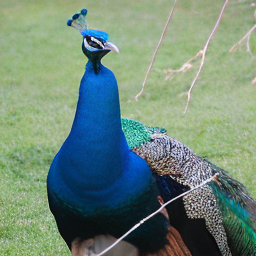

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 50 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [84] #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

# **Implementing xFormers**

In [ ]:
#Important Libraries:
!pip install xformers --upgrade
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Mlp
from abc import ABCMeta, abstractmethod
from dataclasses import asdict, dataclass
from typing import Optional, Type, TypeVar

from xformers._deprecation_warning import deprecated_function
from xformers.components.attention import AttentionMask
from xformers.components.attention import build_attention
from xformers.components.attention import Attention
from xformers.components.attention import ScaledDotProduct
from xformers.ops import memory_efficient_attention

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.1 MB/s eta 0:00:00


<ipython-input-4-9f11135014d8>:14: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import AttentionMask


Original Attention Block

<class 'timm.models.vision_transformer.Attention'>
For batch size 50, time taken to sample 200 images is 11.31 seconds
For batch size 100, time taken to sample 200 images is 20.74 seconds
For batch size 150, time taken to sample 200 images is 31.16 seconds
For batch size 200, time taken to sample 200 images is 40.20 seconds
For batch size 250, time taken to sample 200 images is 52.20 seconds


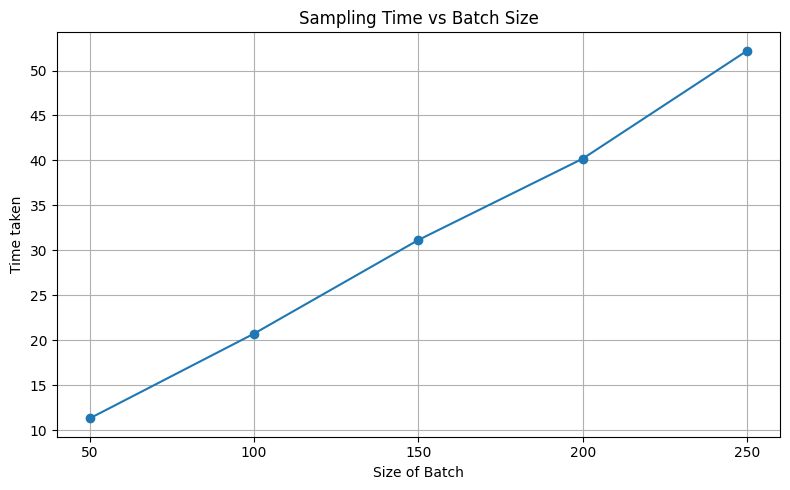

In [ ]:
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):

        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def DiT_XL_2(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=2, num_heads=16, **kwargs)

def DiT_XL_4(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=4, num_heads=16, **kwargs)

def DiT_XL_8(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=8, num_heads=16, **kwargs)

def DiT_L_2(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)

def DiT_L_4(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=4, num_heads=16, **kwargs)

def DiT_L_8(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=8, num_heads=16, **kwargs)

def DiT_B_2(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)

def DiT_B_4(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=4, num_heads=12, **kwargs)

def DiT_B_8(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=8, num_heads=12, **kwargs)

def DiT_S_2(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)

def DiT_S_4(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=4, num_heads=6, **kwargs)

def DiT_S_8(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=8, num_heads=6, **kwargs)


DiT_models = {
    'DiT-XL/2': DiT_XL_2,  'DiT-XL/4': DiT_XL_4,  'DiT-XL/8': DiT_XL_8,
    'DiT-L/2':  DiT_L_2,   'DiT-L/4':  DiT_L_4,   'DiT-L/8':  DiT_L_8,
    'DiT-B/2':  DiT_B_2,   'DiT-B/4':  DiT_B_4,   'DiT-B/8':  DiT_B_8,
    'DiT-S/2':  DiT_S_2,   'DiT-S/4':  DiT_S_4,   'DiT-S/8':  DiT_S_8,
}

model = DiT_models['DiT-B/8'](input_size=latent_size).to(device)

def plot_batch_timing(batch_sizes, times, title="Sampling Time vs Batch Size"):
    plt.figure(figsize=(8, 5))
    plt.plot(batch_sizes, times, marker='o', linestyle='-')
    plt.xlabel("Size of Batch")
    plt.ylabel("Time taken")
    plt.title(title)
    plt.grid(True)
    plt.xticks(batch_sizes)
    plt.tight_layout()
    plt.show()


batch_sizes = [50,100,150,200,250]
times = []


print(type(model.blocks[0].attn))

for bs in batch_sizes:
    x = torch.randn(bs, 4, 32, 32).to(device)
    t = torch.randint(0, 1000, (bs,), device=device)
    y = torch.randint(0, 1000, (bs,), device=device)

    start = time.time()
    with torch.no_grad():
        for _ in range(200):
            _ = model(x, t, y)
    end = time.time()

    elapsed = end - start

    print(f"For batch size {bs}, time taken to sample 200 images is {elapsed:.2f} seconds")
    times.append(elapsed)

plot_batch_timing(batch_sizes, times)

xFormers Attention Block

For batch size 50, time taken to sample 200 images is 10.50 seconds
For batch size 100, time taken to sample 200 images is 19.32 seconds
For batch size 150, time taken to sample 200 images is 28.65 seconds
For batch size 200, time taken to sample 200 images is 36.32 seconds
For batch size 250, time taken to sample 200 images is 48.18 seconds


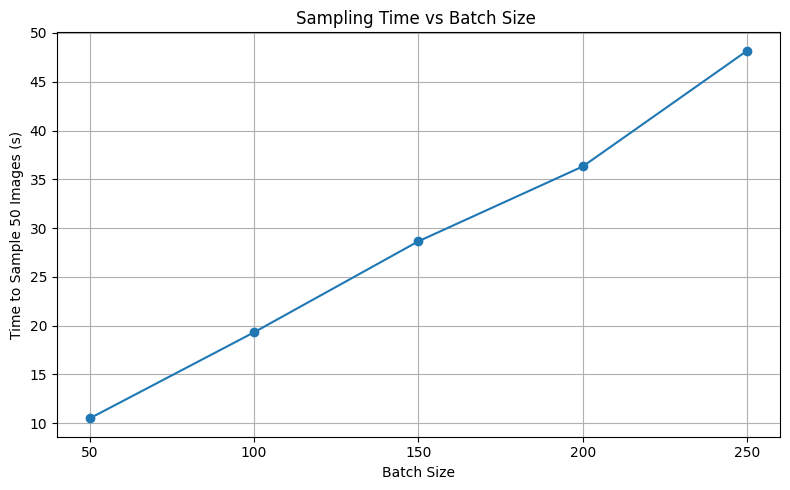

In [ ]:
import time

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class AttentionConfig:
    """Parameters required for all Attentions.
    Can accept and store extra parameters.
    """

    name: str  # the registered name for this attention mechanism
    dropout: float  # dropout probability


Self = TypeVar("Self", bound="Attention")


# Define the common interface, every attention block needs to derive from it
class Attention(nn.Module, metaclass=ABCMeta):
    r"""The base Attention mechanism, which is typically a sub-part of the multi-head attention"""

    _causal_mask: Optional[AttentionMask] = None

    @abstractmethod
    def __init__(self, dropout: Optional[float] = None, *args, **kwargs):
        super().__init__()
        deprecated_function(self)

        # Requires the inputs to be projected
        self.requires_input_projection = True

        # Whether the head dimension needs to be present (if not it can be folded into the batch dimension)
        self.requires_head_dimension = False

        # key padding mask and attention mask must be passed in as separate arguments instead of a merged attention mask
        self.requires_separate_masks = False

        # Requires that K and Q have the same sequence length
        self.requires_same_k_q_dimensions = False

        # Whether the attention owns the single head/multihead mechanism
        # so that the MHA wrapper should skip it
        self.requires_skip_multi_head = False

        # This attention requires a context length which is squared, often due to 2D pooling
        self.requires_squared_context = False

        # Whether this attention mechanism supports attention masks
        self.supports_attention_mask = True
        self.supports_key_padding_mask = False

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

def plot_batch_timing(batch_sizes, times, title="Sampling Time vs Batch Size "):
    plt.figure(figsize=(8, 5))
    plt.plot(batch_sizes, times, marker='o', linestyle='-')
    plt.xlabel("Batch Size")
    plt.ylabel("Time to Sample 50 Images (s)")
    plt.title(title)
    plt.grid(True)
    plt.xticks(batch_sizes)
    plt.tight_layout()
    plt.show()

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)

        self.qkv = nn.Linear(hidden_size, hidden_size * 3, bias=False)
        self.attn = build_attention({"name": "scaled_dot_product","dropout": 0.0,"num_heads": num_heads, "dim": hidden_size, "use_flash_attention": True,
})
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x_norm = modulate(self.norm1(x), shift_msa, scale_msa)
        q, k, v = self.qkv(x_norm).chunk(3, dim=-1)
        x_attn = memory_efficient_attention(q, k, v, attn_bias=None)
        x = x + gate_msa.unsqueeze(1) * x_attn

        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
    DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def DiT_XL_2(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=2, num_heads=16, **kwargs)

def DiT_XL_4(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=4, num_heads=16, **kwargs)

def DiT_XL_8(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=8, num_heads=16, **kwargs)

def DiT_L_2(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)

def DiT_L_4(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=4, num_heads=16, **kwargs)

def DiT_L_8(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=8, num_heads=16, **kwargs)

def DiT_B_2(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)

def DiT_B_4(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=4, num_heads=12, **kwargs)

def DiT_B_8(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=8, num_heads=12, **kwargs)

def DiT_S_2(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)

def DiT_S_4(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=4, num_heads=6, **kwargs)

def DiT_S_8(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=8, num_heads=6, **kwargs)


DiT_models = {
    'DiT-XL/2': DiT_XL_2,  'DiT-XL/4': DiT_XL_4,  'DiT-XL/8': DiT_XL_8,
    'DiT-L/2':  DiT_L_2,   'DiT-L/4':  DiT_L_4,   'DiT-L/8':  DiT_L_8,
    'DiT-B/2':  DiT_B_2,   'DiT-B/4':  DiT_B_4,   'DiT-B/8':  DiT_B_8,
    'DiT-S/2':  DiT_S_2,   'DiT-S/4':  DiT_S_4,   'DiT-S/8':  DiT_S_8,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiT_models['DiT-B/8'](input_size=latent_size).to(device)

batch_sizes = [50,100,150,200,250]
times = []

for bs in batch_sizes:
    x = torch.randn(bs, 4, 32, 32).to(device)
    t = torch.randint(0, 1000, (bs,), device=device)
    y = torch.randint(0, 1000, (bs,), device=device)

    start = time.time()
    with torch.no_grad():
        for _ in range(200):
            _ = model(x, t, y)
    end = time.time()

    elapsed = end - start
    print(f"For batch size {bs}, time taken to sample 200 images is {elapsed:.2f} seconds")


    times.append(elapsed)

plot_batch_timing(batch_sizes, times)